# Peaked Quantum Circuits: Exploring Verifiable Quantum Advantage

**Author:**  <span style="color: #2edee4;">**Niloy Kumar Mondal**</span>

> Senior Undergrad Student,  
> Department of Computer Science and Engineering  
> Bangladesh University of Engineering and Technology (BUET)  
> Dhaka, Bangladesh  
> Email: nkm2105044@gmail.com

---

## Abstract

How do you prove a quantum computer actually did something no classical computer can? Are there problems that a quantum computer can solve efficiently, but that would take a classical machine an unreasonable perhaps even cosmic amount of time? These questions sit at the heart of quantum advantage, one of the most important unsolved puzzles of quantum advantage.


<div align="center">
<img src="images/dwave_quantum_computer.png" width="34%" alt="D-Wave quantum computer" style="margin-right: 10px;">
<img src="images/ibm_quantum_computer.jpg" width="48%" alt="IBM quantum computer">
<br>
<em>D-Wave Quantum Computer</em> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <em>IBM Quantum Computer</em>
</div>




To answer these questions, researchers design specific computational tasks often based on sampling from quantum circuits and then try to show two things: first, that a quantum computer can perform the task efficiently, and second, that no classical computer can do the same without an exponential blowup in time or resources. 



This approach led to landmark experiments like Google's 2019 quantum supremacy demonstration, where their Sycamore processor completed a sampling task in 200 seconds that would have taken classical supercomputers an estimated 10²⁵ years <sup>[1]</sup>. 


<div align="center">

<img src="images/05_Hero_Shot.gif" width="500" alt="Peaked circuit sampling hero animation">
</div>

But proving quantum advantage isn't just about speed, it also demands verification. If a quantum computer produces an answer that no classical machine can reproduce, how do we check that the answer is actually correct? This tension between hardness and verifiability is what drives the search for better quantum advantage candidates.

<br>

Peaked quantum circuits are a candidate for demonstrating quantum advantage, as introduced by Aaronson and Zhang <sup>[[2]](#ref2)</sup>, which change the game. 

<br>

A peaked quantum circuit is a quantum circuit whose output probability distribution concentrates heavily on a single computational basis state,i.e. a hidden bitstring.

<br>

However, unlike random circuits, peaked circuits are much easier to verify because their outputs have high concentrations on a computational basis state: simply run them on a quantum computer and check whether you recover the correct hidden bitstring. Verification in classical computer grows exponentially with the number of qubits. So, we might get a quantum advantage by this property.

<br>

<div align="center">
<img src="images/peaked_circuit.png" width="500" alt="Peaked Circuit Diagram">
<br>
<em><strong>Figure 1:</strong> Example of a peaked circuit output distribution showing high concentration on a single computational basis state</em>
</div>

<br>

A good peaked circuit must look indistinguishable from a random circuit to any classical observer, much like a cryptographic hash function: easy to verify, hard to reverse-engineer. So, peaked circuit have potential to be used in ***post quantum cryptography***.

<br>
In this challenge, you will learn what peaked circuits are, how to construct them by augmenting random circuits with optimized peaking layers, and how to verify quantum outputs using the hidden peak and a bunch of mathematical proofs that is needed to deeply understand.

---

## 📑 Table of Contents

1. [What is a Peaked Quantum Circuit?](#what-is-a-peaked-quantum-circuit)
   - [Task 1](#task-1)
   - [Formal Definition of Delta Peakedness](#formal-definition-of-delta-peakedness)
   - [Task 2](#task-2)
   - [Task 3](#task-3)
2. [How Peaked Circuits Enable Verifiable Quantum Advantage](#how-peaked-circuits-enable-verifiable-quantum-advantage)
3. [Peaked Circuit Design](#peaked-circuit-design)
   - [Generating Peaked Circuits: The τr + τp Construction](#generating-peaked-circuits-the-τr--τp-construction)
   - [Task 4: Design a Peaked Quantum Circuit](#task-4)
4. [Peaked Circuits are Rare in RQCs](#peaked-circuits-are-rare-in-rqcs)
   - [What is Collision Probability?](#what-is-collision-probability)
   - [Task 5](#task-5)
   - [Case Study: All States are Equiprobable](#case-study--all-states-are-equiprobable)
   - [The Well-Spread Property](#the-well-spread-property)
5. [Training Peaking Layers](#training-peaking-layers)
   - [Training the Circuit to Get the Bitstring at 0011](#training-the-circuit-to-get-the-bitstring-at-0011)
6. [Experiments](#experiments-related-to-bot-not-limited-to-the-paper)
   - [Experiment 1: How Few Peaking Layers Can You Get Away With?](#experiment-1-how-few-peaking-layers-can-you-get-away-with)
   - [Experiment 2: Can You Build a Better Peaking Layer?](#experiment-2-can-you-build-a-better-peaking-layer)
   - [Experiment 3: Does the Optimizer Matter?](#experiment-3-does-the-optimizer-matter)
   - [Experiment 4: Does It Scale?](#experiment-4-does-it-scale)
   - [Experiment 5: Witnessing the Barren Plateau](#experiment-5-witnessing-the-barren-plateau)
   - [Experiment 6: Does Your Peaked Circuit Still Look Random?](#experiment-6-does-your-peaked-circuit-still-look-random)
7. [References](#references)

---


## What is a Peaked Quantum Circuit?

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">
A peaked quantum circuit is a quantum circuit whose output distribution is highly concentrated on a single computational basis state 'the peak' rather than being spread uniformly across all possible outcomes.
<br>


Let's get our hands dirty...


In [12]:
from platform import python_version
print(python_version())

3.10.0


In [13]:
# %pip install -r requirements.txt

Install the package below, which is taken from Quantum Global Summer School 2025 that handles Qiskit versions nicely

In [14]:
import qiskit
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.1.2


In [15]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
import math
import numpy as np
from scipy.optimize import minimize
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

In [16]:
def measure_qc(qc, shots=1000, backend=AerSimulator(),optimization_level=1):
    #check if the circuit has measurements, if not add them
    if not qc.count_ops().get('measure', 0):    
        qc.measure_all()


    backend = AerSimulator()
    sampler = Sampler(mode=backend)


    pm = generate_preset_pass_manager(backend=backend, optimization_level=optimization_level)
    job = sampler.run(pm.run([qc]), shots=shots)


    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    return counts_list


> **📝 Note:** This task includes a coding exercise with `#TODO` sections. You will need to fill in the missing code where indicated to complete the challenge.

## Task 1
Given a simple 2-qubit peaked quantum circuit, find the peaked bitstring.



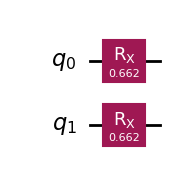

In [17]:
qc = QuantumCircuit(2)

theta = 2 * math.acos(0.8 ** 0.25)
qc.rx(theta, 0)
qc.rx(theta, 1)

qc.draw("mpl")

In [18]:
#TODO: Find the probablity of measuring 00, 01, 10 and 11 


#TODO: Plot the histogram of the results

### Formal Definition of delta peakedness

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**Definition 1.1** (Peaked Circuit) <sup>[[2]](#ref2)</sup>

Given δ ∈ (0, 1], we call a unitary C **δ-peaked** if:

<div align="center">

$$\max_{s \in \{0,1\}^n} |\langle s|C|0^n\rangle|^2 \geq \delta$$

</div>

with a corresponding peak weight $\delta_s \equiv |\langle s|C|0^n\rangle|^2$.

</div>


## Task 2
Can you prepare a Qauntum Circuit that is 0.7-peaked on the state |00> ?
That means, when you measure, the probability of getting |00⟩ as output must be ≥ 70%


In [19]:
qc = QuantumCircuit(2)

#TODO: find theta so that peak is on 00 state

theta = ?

qc.rx(theta, 0)
qc.rx(theta, 1)

qc.draw("mpl")

SyntaxError: invalid syntax (1775852314.py, line 5)

In [ ]:
# TODO: verify your results plotting histogram here

## Task 3
Move the peaked state from 00 to 01

In [ ]:
qc_modified = QuantumCircuit(2)

qc_modified.rx(theta, 0)
qc_modified.rx(theta, 1)

#TODO : add some gates to the circuit to move the peak to 01 state

#TODO : verify your results plotting histogram here



## How Peaked Circuits Enable Verifiable Quantum Advantage

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**The Verification Protocol:**  <sup>[[1]](#ref1)</sup>

1. A challenger sends a quantum circuit C to an alleged quantum computer
2. The circuit is either **uniformly random** OR from a **peaked distribution** (the challenger knows which)
3. The quantum computer runs C multiple times and checks: does one output appear unusually often?
4. If a clear "peak" emerges → the circuit was peaked; if outputs look uniform → it was random

**Intuition**
- A **real quantum computer** can easily distinguish peaked vs. random circuits by sampling
- The open question: Can a **classical computer** also distinguish them efficiently?
- If classical computers cannot, this gives us a way to **verify** that a device is truly quantum!

</div>

# Peaked Circuit Design
### Generating Peaked Circuits: The τr + τp Construction <sup>[[1]](#ref1)</sup>

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**Key Terminologies:**

| Symbol | Name | Meaning |
|--------|------|---------|
| τr | Random Layers | Layers of gates chosen **uniformly at random** from a distribution (e.g., Haar-random 2-qubit gates) |
| τp | Peaking Layers | Layers of gates that are **optimized/tuned** to maximize the circuit's peakedness |
| δ | Peakedness | The probability of measuring a specific output state (e.g., \|00...0⟩) |

</div>

---

### The Protocol: How It Works

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**Step-by-step construction:**

1. **Start** with initial state |0ⁿ⟩ (all qubits in zero state)

2. **Apply τr random layers:** These scramble the quantum state, spreading amplitude across many basis states 

3. **Apply τp peaking layers:** These are carefully chosen gates that steer the amplitude back toward a specific output state

4. **Result:** A circuit that looks random but has a hidden peak at one output


# Task 4:
Design a Peaked Quantum Circuit using The τr + τp Construction

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

### Circuit Architecture Reference

<div style="text-align: center;">
    <img src="images/rqc_pqc.png" alt="Random and Peaking Circuit Construction" width="300">
</div>

</div>

---

##  Given the random layers, design the peaking layers
### case 1 : where number of peaking layer is greater than number of random layer
<div style="background-color: #1a1a2e; color: #e6e6e6; padding: 25px; border-left: 4px solid #e94560; border-radius: 8px; margin: 20px 0;">

### Design Specifications

| Parameter | Value |
|-----------|-------|
| **Number of Qubits** | 4 |
| **Random Layers (τr)** | 5 |
| **Peaking Layers (τp)** | 6 |
| **Target State** | \|0011⟩ |
| **Minimum Peakedness (δ)** | ≥ 50% |

</div>



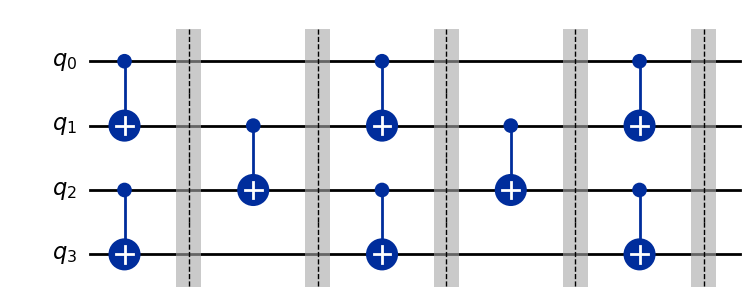

In [8]:
qc = QuantumCircuit(4)

def add_simple_random_layer(qc, layer_num):
    
    #brickwall pattern entangling
    if layer_num % 2 == 0:
        qc.cx(0, 1)
        qc.cx(2, 3)
    else:
        qc.cx(1, 2)
    
    qc.barrier()


num_random_layers = 5

for i in range(num_random_layers):
    add_simple_random_layer(qc, i)

qc.draw("mpl")

In [ ]:
def add_peaking_layer(qc):

    #TODO : design the peaking layer

    qc.barrier()


num__peaking_layers = 6
add_peaking_layer(qc)
qc.draw("mpl")

### 💡 Hint

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #f39c12; border-radius: 5px;">

For any unitary matrix U:

$$U \cdot U^\dagger = I$$

# Peaked circuits are rare in RQCs

### We need to understand some preliminaries before understanding why peaked circuits sampled from random circuits distribution are rare.
---
### What is Collision Probability?

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

Given a quantum circuit $C$ acting on $|0^n\rangle$, the output distribution is:

$$p_C[s] = |\langle s | C | 0^n \rangle|^2 \quad \text{for each } s \in \{0,1\}^n$$

The **collision probability** is defined as:

$$\pi_C = \sum_{s \in \{0,1\}^n} p_C[s]^2$$

**Intuition:** This is the probability that two independent runs of the circuit produce the *same* output string. If the output is perfectly uniform, $\pi_C = 2^{-n}$ (very small). If the output is concentrated on one string, $\pi_C \approx 1$ (very large).

</div>

# Task 5

Implement the following function and experiment with a case-study

In [ ]:
def collision_probability(probabilities):
    """
    Args:
        probabilities: numpy array of output probabilities

    Returns:
        float: the collision probability π_C
    """

    # TODO: Compute the collision probability
    
    pi_C = ?
    
    return pi_C

### Case Study : All states are equiprobable

Applying Hadamard to all 4 qubits creates an equal superposition over all $2^4 = 16$ states:

$$H^{\otimes 4}|0000\rangle = \frac{1}{\sqrt{16}}\sum_{s \in \{0,1\}^4} |s\rangle$$

So each output probability is:

$$p_C[s] = \frac{1}{16} \quad \text{for all } s$$

The collision probability is:

$$\pi_C = \sum_{s=0}^{15} p_C[s]^2 = \sum_{s=0}^{15} \left(\frac{1}{16}\right)^2 = 16 \times \frac{1}{256} = \frac{1}{16} = \frac{1}{2^n} = 0.0625$$

This is the **minimum possible** collision probability for $n = 4$ qubits a perfectly uniform distribution means collisions are maximally rare.

In [ ]:
qc = QuantumCircuit(4)
qc.h([0, 1, 2, 3])

# TODO: verify the collision probability by measuring the circuit

---



#### The Well-Spread Property

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**Definition 2.1 (Well-Spread Ensemble)** <sup>[[1]](#)</sup>

A circuit ensemble is **well-spread** if the expected collision probability satisfies:

$$\mathbb{E}_C[\pi_C] \leq \frac{\gamma}{2^n}$$

for some constant $\gamma$.

In other words, on average, the collision probability is close to the uniform value $1/2^n$, with $\gamma$ measuring how far off it is.

</div>


### Probability of finding peaked circuits in a well-spread ensemble

**Statement:** Let $P_\delta$ be the probability of finding a $\delta$-peaked circuit in a well-spread ensemble. Then:

$$P_\delta = O\left(\frac{1}{\delta^2 \cdot 2^n}\right)$$

---

**Proof:**
 Start from the definition of collision probability. For *any* $\delta$-peaked circuit $C$, by Definition 1.1 there exists some string $s^*$ with $p_C[s^*] \geq \delta$. Therefore:

$$\pi_C = \sum_{s} p_C[s]^2 \geq \max_{s} \, p_C[s]^2 \geq \delta^2$$

This is because the sum of squares is always at least as large as the largest squared term.

Now take the expectation over all circuits $C$ in the ensemble. Split the expectation into peaked and non-peaked circuits:

$$\mathbb{E}_C[\pi_C] = P_\delta \cdot \mathbb{E}[\pi_C \mid C \text{ is } \delta\text{-peaked}] + (1 - P_\delta) \cdot \mathbb{E}[\pi_C \mid C \text{ is not } \delta\text{-peaked}]$$

Since $\pi_C \geq \delta^2$ for every $\delta$-peaked circuit (from Step 1), and $\pi_C \geq 0$ always:

$$\mathbb{E}_C[\pi_C] \geq P_\delta \cdot \delta^2 + (1 - P_\delta) \cdot 0 = \delta^2 \cdot P_\delta$$

Apply the well-spread condition:

$$\mathbb{E}_C[\pi_C] \leq \frac{\gamma}{2^n}$$

Combine Steps 2 and 3:

$$\delta^2 \cdot P_\delta \leq \mathbb{E}_C[\pi_C] \leq \frac{\gamma}{2^n}$$

Solve for $P_\delta$:

$$\boxed{P_\delta \leq \frac{\gamma}{\delta^2 \cdot 2^n} = O\left(\frac{1}{\delta^2 \cdot 2^n}\right)}$$


---

**What this tells us:** For $\delta = \Omega(2^{-0.49n})$, we get $P_\delta \leq \gamma \cdot 2^{-0.02n}$, which is exponentially small in $n$. This means finding even *modestly* peaked circuits by random chance is essentially impossible in a well-spread ensemble you need something beyond random sampling to produce them.




# Training Peaking Layers

We proved that random circuits alone are almost never peaked — the probability decays exponentially with system size. Therefore, we need additional **trainable peaking layers** to concentrate the output distribution onto a single bitstring.

---

### The Construction

The circuit $C(\boldsymbol{\theta})$ has two parts:

1. **$\tau_r$ random layers** — fixed Haar-random two-qubit gates in a brickwall pattern
2. **$\tau_p$ peaking layers** — parameterized quantum circuits (PQC) with trainable parameters $\boldsymbol{\theta}$

The parameters $\boldsymbol{\theta}$ are optimized via gradient descent to maximize the peak weight on the all-zero string:

$$\max_{\boldsymbol{\theta}} \; \delta_{0^n}(C(\boldsymbol{\theta})) = \max_{\boldsymbol{\theta}} \; |\langle 0^n | C(\boldsymbol{\theta}) | 0^n \rangle|^2$$

In other words, we train the peaking layers to funnel as much output probability as possible onto $|0^n\rangle$, while the random layers remain frozen.


## The Central Question

<div style="background-color: #030303; color: #e6e6e6; padding: 20px; border-left: 4px solid #2edee4; border-radius: 5px;">

**Problem 1.3** <sup>[[1]](#ref1)</sup>

What happens when we have **far fewer** peaking layers than random layers?

Suppose $\tau_p = \tau_r / 2$, or $\tau_p = \sqrt{\tau_r}$: can we obtain a nontrivially peaked circuit then, with high probability over the $\tau_r$ random layers?

</div>

## Training the circuit to get the bitstring at 0011

In [9]:
def add_simple_random_layer(qc, n_qubits, layer_num):
    """Fixed random brickwall layer"""
    if layer_num % 2 == 0:
        pairs = [(i, i+1) for i in range(0, n_qubits-1, 2)]
    else:
        pairs = [(i, i+1) for i in range(1, n_qubits-1, 2)]
    for q1, q2 in pairs:
        qc.cx(q1, q2)
    qc.barrier()


def add_peaking_layer(qc, n_qubits, layer_num):
    
    params = ParameterVector(f"peak_{layer_num}", 2 * n_qubits)

    for q in range(n_qubits):
        qc.ry(params[2 * q], q)
        qc.rz(params[2 * q + 1], q)

    if layer_num % 2 == 0:
        pairs = [(i, i + 1) for i in range(0, n_qubits - 1, 2)]
    else:
        pairs = [(i, i + 1) for i in range(1, n_qubits - 1, 2)]
    for q1, q2 in pairs:
        qc.cx(q1, q2)

    qc.barrier()
    return list(params)


def build_circuit(n_qubits, num_random_layers, num_peaking_layers, param_values):
    qc = QuantumCircuit(n_qubits)

    # τ_r fixed random layers
    for i in range(num_random_layers):
        add_simple_random_layer(qc, n_qubits, i)

    # τ_p trainable peaking layers
    all_params = []
    for layer in range(num_peaking_layers):
        layer_params = add_peaking_layer(qc, n_qubits, layer)
        all_params.extend(layer_params)

    # Assign numerical values to parameters
    assignment = {all_params[i]: param_values[i] for i in range(len(all_params))}
    return qc.assign_parameters(assignment)


def target_probability(qc, target):
    probs = Statevector.from_instruction(qc).probabilities_dict()
    return probs.get(target, 0.0)


def objective(x, n_qubits, num_random_layers, num_peaking_layers, target):
    qc = build_circuit(n_qubits, num_random_layers, num_peaking_layers, x)
    return -target_probability(qc, target)


Qubits: 4
Target: |0011⟩
τ_r = 40, τ_p = 6
Trainable parameters: 48
Optimized peakedness δ = 0.9466


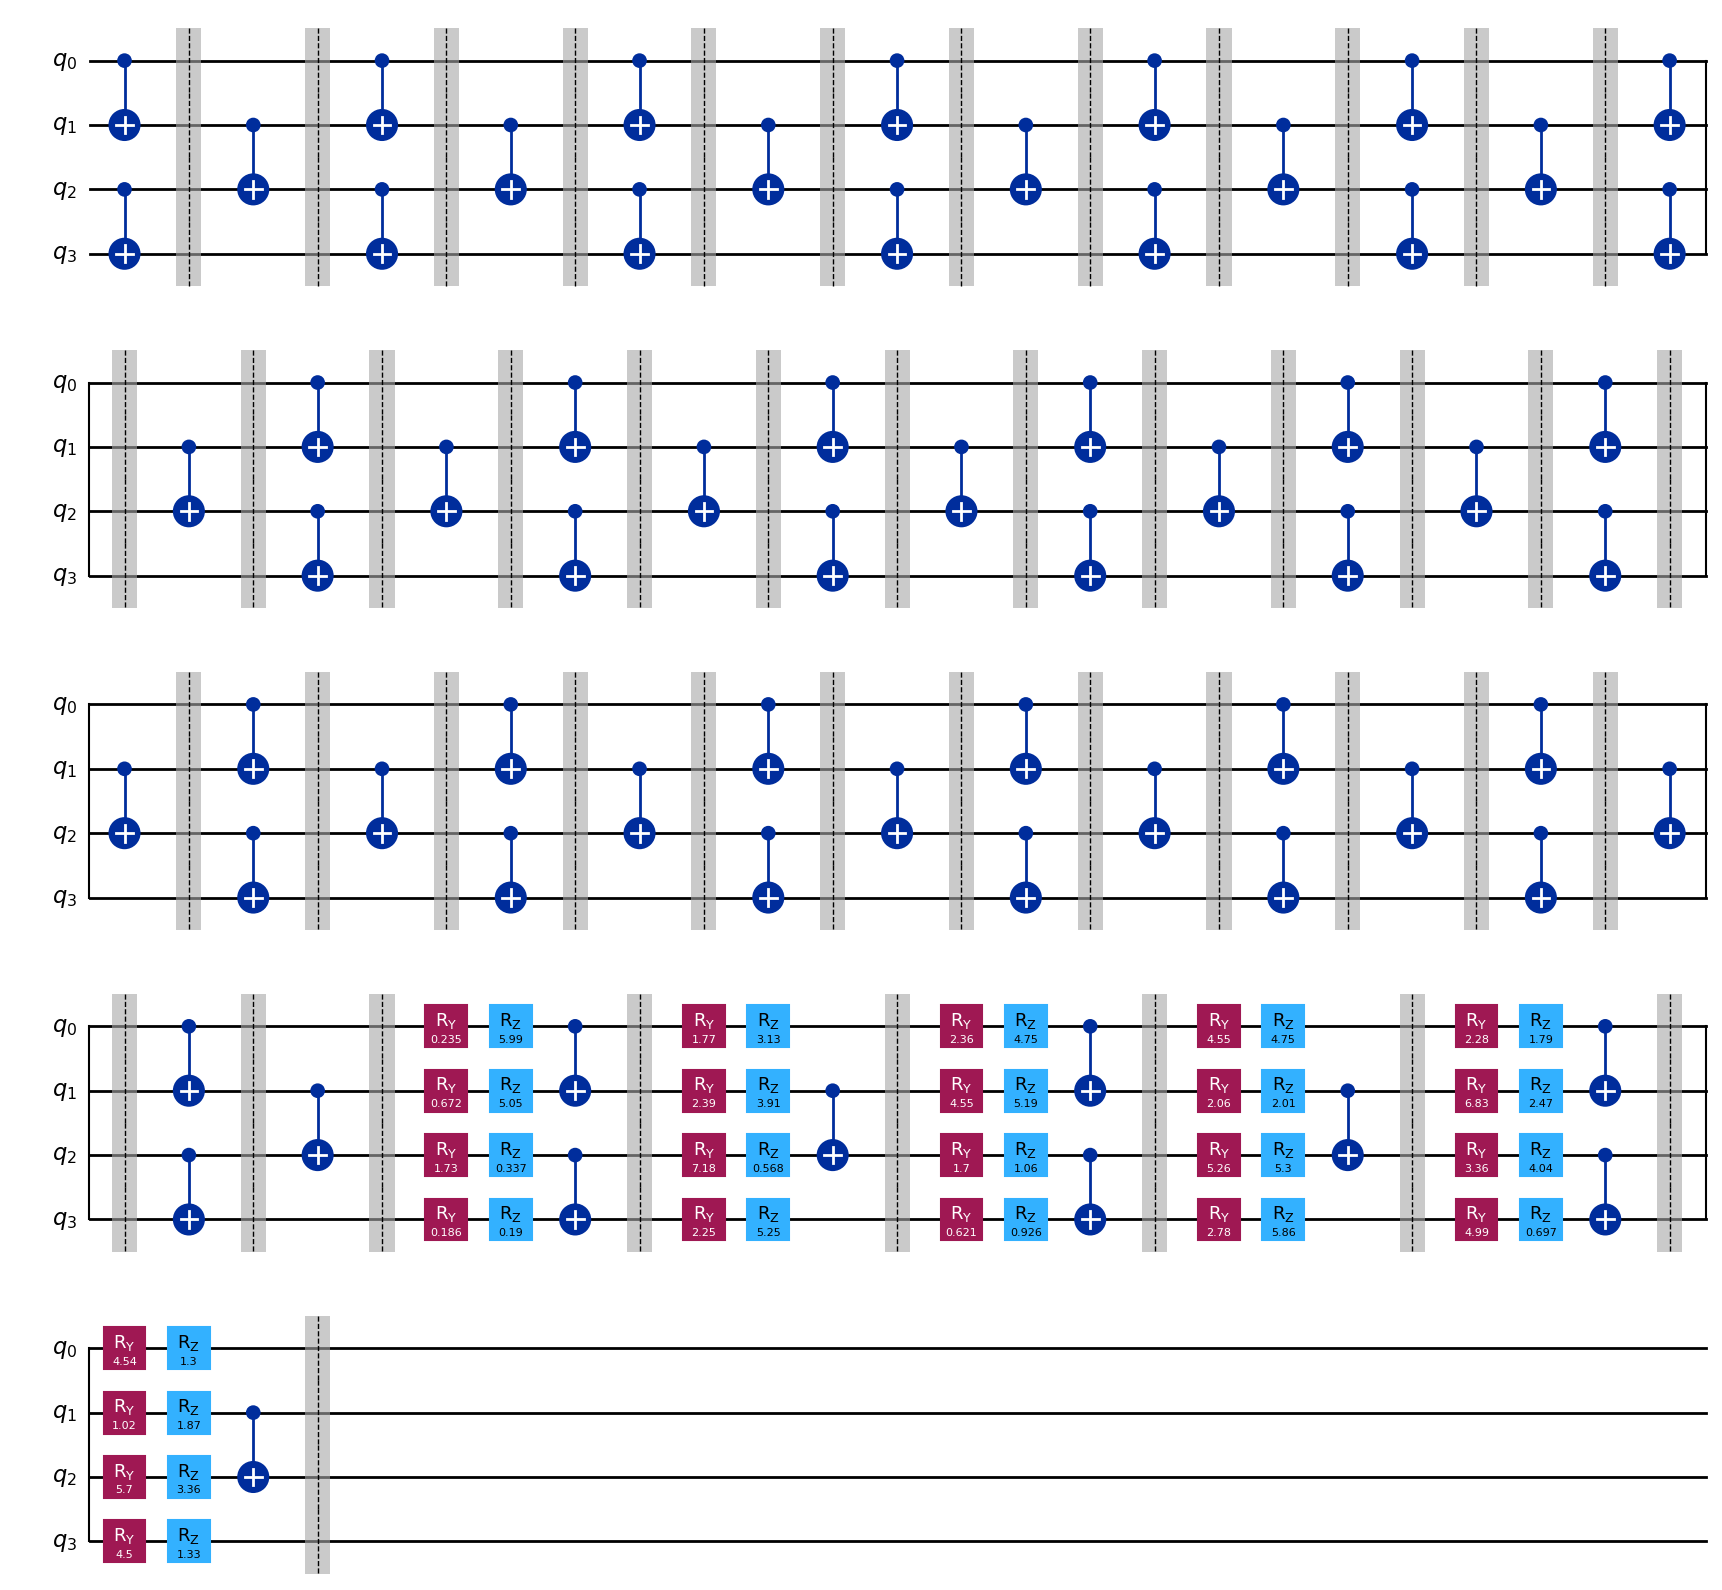

In [10]:
n_qubits = 4
target = "0011"
num_random_layers = 40     # τ_r
num_peaking_layers = 6     # τ_p   [Experiment as per the instruction above]
num_params = 2 * n_qubits * num_peaking_layers



# Optimize
x0 = np.random.uniform(0.0, 2 * np.pi, size=num_params)

result = minimize(
    objective, x0,
    args=(n_qubits, num_random_layers, num_peaking_layers, target),
    method="COBYLA",
    options={"maxiter": 200}
)


best_prob = -result.fun
qc_trained = build_circuit(n_qubits, num_random_layers, num_peaking_layers, result.x)

print(f"Qubits: {n_qubits}")
print(f"Target: |{target}⟩")
print(f"τ_r = {num_random_layers}, τ_p = {num_peaking_layers}")
print(f"Trainable parameters: {num_params}")
print(f"Optimized peakedness δ = {best_prob:.4f}")

qc_trained.draw("mpl")

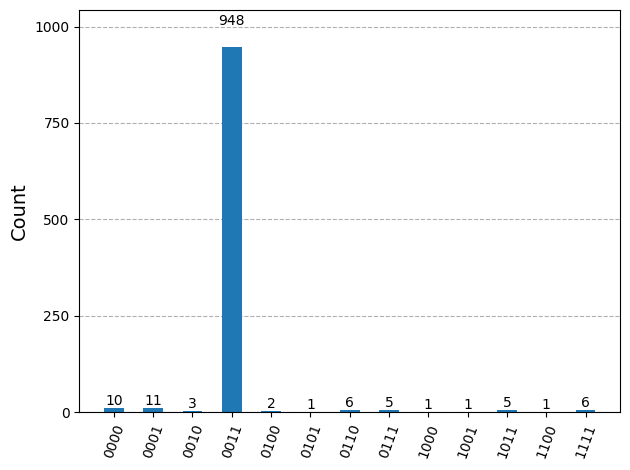

In [11]:
plot_histogram(measure_qc(qc_trained))

## Experiments related to bot not limited to the paper.<sup>[[1]](#ref1)</sup>

You've built a working peaked circuit. Now it's time to break things, push limits, and see what happens. These experiments are inspired by the paper but you're free to go beyond them.

---

### Experiment 1: How Few Peaking Layers Can You Get Away With?

Keep `n_qubits = 4` and `num_random_layers = 10`. Now try `num_peaking_layers` from 1 all the way up to 10.

- At what point does the peakedness $\delta$ cross 0.5? Can you get there with just 2 or 3 layers?
- Plot your peakedness $\delta$ against $\tau_p$ — you should see a curve that rises fast and then flattens out.
- The paper proved a lower bound (Theorem 2.4): you need at least $\tau_p = \Omega((\tau_r / n)^{0.19})$ layers. Does your experiment agree? Are you hitting that floor, or beating it?

---

### Experiment 2: Can You Build a Better Peaking Layer?

Our peaking layer is simple — just $R_y$, $R_z$, and a few CNOTs. But maybe there's a smarter design. Try these variations and see which one gives you the most peakedness per parameter:

- **More rotations:** Add $R_x$ so each qubit gets 3 parameters instead of 2
- **Richer entanglement:** Replace the fixed CNOTs with fully parameterized two-qubit gates
- **Different connectivity:** Instead of the brickwall pattern, let every qubit talk to every other qubit

The question is: which architecture squeezes the most peakedness out of the fewest parameters?

---

### Experiment 3: Does the Optimizer Matter?

The paper warns about **barren plateaus** — the gradients vanish exponentially as the system grows, making optimization brutally hard. Let's see this in action. Try swapping out the optimizer:

- `COBYLA` — our current gradient-free workhorse
- `Nelder-Mead` — another gradient-free method, uses a simplex
- `L-BFGS-B` — a gradient-based method (does it struggle?)
- `SPSA` — randomly perturbs parameters to estimate gradients, popular in quantum computing

Run each optimizer 10 times with different random seeds. Which one finds the highest $\delta$ most reliably? Which gives up early? And crucially — does gradient-based optimization fall apart when you crank up `n_qubits`?

---

### Experiment 4: Does It Scale?

This is the big one. Fix the ratio $\tau_p / \tau_r = 1/2$ and set $\tau_r = n$. Now increase `n_qubits` from 4 to 10 (or higher if you're patient).

- Plot your optimized $\delta$ vs $n$ on a log scale — it should look like a straight line going down
- Fit it to $\delta = c \cdot a^{-n}$ and find the base $a$
- The paper found $a \approx 1.189$ using Haar-random gates. Your random layers are simpler CNOTs — do you get a similar scaling, or does the gate set change things?

If you can extrapolate your fit to $n = 50$, what peakedness would you predict? Is it still detectable in an experiment?

---

### Experiment 5: Witnessing the Barren Plateau

The paper calls this the main bottleneck (Section 4). Let's actually see it:

- For each system size $n = 4, 5, 6, \ldots, 10$, generate 50 random parameter initializations
- For each one, numerically estimate the gradient $\partial\delta / \partial\theta_i$ (use finite differences)
- Compute the variance of these gradients across all 50 runs
- Plot gradient variance vs $n$ — if it drops exponentially, you're looking at a barren plateau

Then try the paper's workaround: instead of one optimization run, launch a **batch** of say 20 independent runs with random starting points and keep only the best. How many restarts do you need to consistently find a good solution as $n$ grows?

---

### Experiment 6: Does Your Peaked Circuit Still Look Random?

This one is subtle and gets at the heart of the paper's open question (Problem 1.2). After training your peaked circuit:

- Collect the full output distribution, all $2^n$ probabilities
- Sort them and plot them on a log scale
- On the same plot, overlay the Porter-Thomas curve $p(x) = N e^{-Nx}$ that a truly random circuit would produce
- Now here's the key test: **remove the peaked bitstring** and check whether the remaining $2^n - 1$ probabilities still follow Porter-Thomas. You can use a Kolmogorov-Smirnov test for this.

If the distribution looks random everywhere except at the single peak, that's strong evidence that these circuits could be hard for a classical computer to distinguish from truly random ones — which is exactly the property needed for verifiable quantum advantage.

---

## References

1. <a id="ref1"></a>**Google Quantum AI Team.** (2024). *Meet Willow, our state-of-the-art quantum chip*. Google Research Blog. Retrieved from [https://blog.google/innovation-and-ai/technology/research/google-willow-quantum-chip/](https://blog.google/innovation-and-ai/technology/research/google-willow-quantum-chip/)

2. <a id="ref2"></a>**Aaronson, S., & Zhang, Y.** (2024). *On verifiable quantum advantage with peaked circuit sampling*. arXiv preprint arXiv:2404.14493v2 [quant-ph]. [https://arxiv.org/abs/2404.14493](https://arxiv.org/abs/2404.14493)

3. <a id="ref3"></a>**Arute, F., et al.** (2019). Quantum supremacy using a programmable superconducting processor. *Nature*, 574(7779), 505-510. [https://doi.org/10.1038/s41586-019-1666-5](https://doi.org/10.1038/s41586-019-1666-5)